<a href="https://colab.research.google.com/github/AndresPerelmuter/Clustering/blob/main/Cluster_H%26M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Segmentación de Clientes**
---

1 - Objetivo

2 - Compresión de los datos

3 - Preparación de los datos

4 - Modelado

5 - Insights


## **1 - Objetivo**
---

El objetivo de este trabajo es lograr un mayor conocimiento de los clientes, que permita el despliegue de estrategias de venta que se ajusten a sus características, así como mejorar la toma de decisiones.

Los datos que se utilizaron en este proyecto fueron obtenidos de la plataforma Kaggle (https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview).



## **2 - Comprensión de los Datos**

---




Los datos corresponden a transacciones realizadas entre octubre del 2018 y octubre del 2020.

**Instalación y carga de librerias**

In [1]:
!pip install pyclustertend
!pip install yellowbrick 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import iplot
import plotly.graph_objs as go

from sklearn.metrics import pairwise_distances_argmin_min
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from scipy.spatial.distance import pdist, cdist
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import warnings
warnings.filterwarnings("ignore")

random_seed = 54

np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Funciones a utilizar**

In [4]:
def val_nulos(df):
    s1 = df.isnull().sum().rename('Missing Values')
    return pd.DataFrame(s1)

In [ ]:
#A efectos del analisis de outliers, se considera sustituir los valores atipicos por el percentil 0.1 o 0.9. 
#Se considero de esta manera a efectos de no eliminar información.
def outliers(df):
    for col in df.columns:
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.1,0.90]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]

**Recopilación de datos Iniciales**

In [5]:
transactions = pd.read_csv("/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/transactions_train.csv")
articles = pd.read_csv("/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/articles.csv")
customers = pd.read_csv("/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions = transactions[(transactions['t_dat'] < '2019-11-01')]

In [6]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [7]:
transactions.shape

(18491844, 5)

In [8]:
customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,NaN,NaN,ACTIVE,NONE,24.0,7aa399f7e669990daba2d92c577b52237380662f36480b...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,NaN,NaN,ACTIVE,NONE,21.0,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.0,1.0,ACTIVE,Regularly,21.0,4563fc79215672cd6a863f2b4bf56b8f898f2d96ed590e...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1.0,1.0,ACTIVE,Regularly,18.0,8892c18e9bc3dca6aa4000cb8094fc4b51ee8db2ed14d7...


In [9]:
customers['club_member_status'].value_counts()

ACTIVE        1272491
PRE-CREATE      92960
LEFT CLUB         467
Name: club_member_status, dtype: int64

In [10]:
customers.shape

(1371980, 7)

In [11]:
articles.head(5)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [12]:
articles.shape

(105542, 25)

**Exploración de los Datos**







In [13]:
transactions.describe()

,article_id,price,sales_channel_id
count,1.849184e+07,1.849184e+07,1.849184e+07
mean,6.507392e+08,2.792349e-02,1.693333e+00
std,1.169432e+08,1.979836e-02,4.611099e-01
min,1.087750e+08,1.694915e-05,1.000000e+00
25%,5.995800e+08,1.523729e-02,1.000000e+00
50%,6.811810e+08,2.540678e-02,2.000000e+00
75%,7.283800e+08,3.388136e-02,2.000000e+00
max,8.561730e+08,5.915254e-01,2.000000e+00


In [14]:
transactions.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

Se analiza la distribución de los precios en el dataset de transacciones visualizandose outliers.

<AxesSubplot:ylabel='price'>

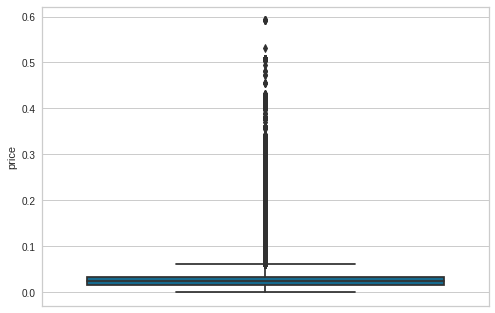

In [15]:
sns.boxplot(y = transactions['price'])

<AxesSubplot:xlabel='price', ylabel='Count'>

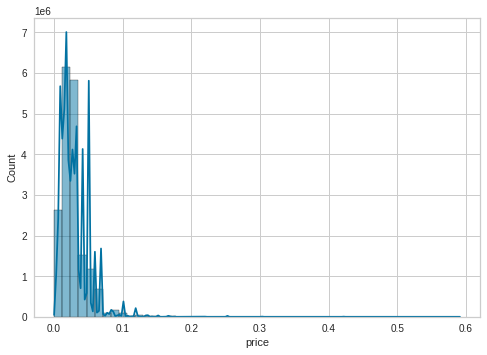

In [16]:
sns.histplot(data=transactions, x="price", palette='winter', bins=50, kde=True)

Se realiza un ánalisis de los precios promedio por artículo asi como su mínimo y máximo.

In [17]:
preciopart = transactions.groupby('article_id', as_index=False).agg(
    Precio_Prom=('price', 'mean'),
    Min_Precio=('price', min),
    Max_Precio=('price', max))
preciopart

,article_id,Precio_Prom,Min_Precio,Max_Precio
0,108775015,0.008149,0.001339,0.009153
1,108775044,0.008134,0.001678,0.008508
2,108775051,0.004980,0.003237,0.008458
3,110065001,0.021511,0.002525,0.025407
4,110065002,0.019296,0.005085,0.025407
...,...,...,...,...
74723,853752001,0.032273,0.027593,0.033881
74724,853932001,0.049077,0.040661,0.050831
74725,854576001,0.041593,0.041593,0.041593
74726,854576003,0.040661,0.033881,0.042356


In [18]:
preciopartdate = transactions.groupby(['t_dat', 'article_id'], as_index=False).agg(
    Precio_Prom=('price', 'mean'),
    Min_Precio=('price', min),
    Max_Precio=('price', max))

In [19]:
preciopartdate

,t_dat,article_id,Precio_Prom,Min_Precio,Max_Precio
0,2018-09-20,108775015,0.008445,0.008068,0.008458
1,2018-09-20,108775044,0.008458,0.008458,0.008458
2,2018-09-20,108775051,0.004929,0.004695,0.005068
3,2018-09-20,110065001,0.023500,0.022864,0.025407
4,2018-09-20,110065002,0.023147,0.021169,0.025407
...,...,...,...,...,...
4395304,2019-10-31,853752001,0.032288,0.031627,0.032949
4395305,2019-10-31,853932001,0.050831,0.050831,0.050831
4395306,2019-10-31,854576001,0.041593,0.041593,0.041593
4395307,2019-10-31,854576003,0.040661,0.033881,0.042356


A continuación, se crea una nueva columna con número de transacción (fecha y número de cliente) con el objetivo de analizar la cantidad de articulos comprados por transacción a efectos de analizar posibles fraudes o errores en la información.

Aqui se ven valores atipicos como la compra de 540 articulos en una transacción. En siguientes puntos se tratara este tema como outliers.

In [20]:
#Se crea un numero de transaccion para poder evaluar las transacciones y analizar posibles errores en ellas. 
transactions['n_trans'] = transactions['t_dat'] + transactions['customer_id']
trans_dia = transactions.groupby('n_trans', as_index=False).agg(Cantidad=('article_id', 'count')).sort_values(by=['Cantidad'], ascending=False)

In [21]:
trans_dia.sort_values(by=['Cantidad'], ascending=False)
trans_dia

,n_trans,Cantidad
330656,2018-10-14d00063b94dcb1342869d4994844a2742b5d6...,570
1161741,2018-12-17c2f0cdda2dc3042ccd9fcd8253fd8e368769...,336
1489900,2019-01-1362fd7d41b587c72a95c31eca5046019ce4e8...,221
333665,2018-10-15246734d8f4a4252fcd5c7aa525055a2804b9...,220
1869380,2019-02-1694665b46e194622ccdbcadc0170f13a2f8ed...,199
...,...,...
3866531,2019-07-1480282b0e1aa004db17ad2ffa8800d7867182...,1
1675224,2019-01-30069648ee5e6b6924829016a760a3c71dff96...,1
1675225,2019-01-300698e1cbddeb7184ec72ab5ff92952620427...,1
1675226,2019-01-3006afdf7824c7a7fc828c36ca23aa51da0d5b...,1


<AxesSubplot:xlabel='Cantidad'>

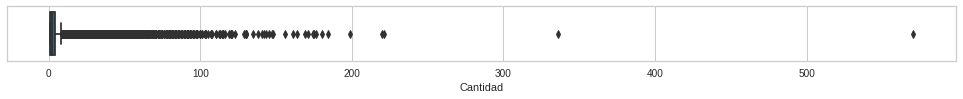

In [22]:
plt.figure(figsize=(17,1))
sns.boxplot(x = trans_dia['Cantidad'])

In [23]:
customers.describe()

,FN,Active,age
count,476930.0,464404.0,1.356119e+06
mean,1.0,1.0,3.638696e+01
std,0.0,0.0,1.431363e+01
min,1.0,1.0,1.600000e+01
25%,1.0,1.0,2.400000e+01
50%,1.0,1.0,3.200000e+01
75%,1.0,1.0,4.900000e+01
max,1.0,1.0,9.900000e+01


In [24]:
customers.dtypes

customer_id                object
FN                        float64
Active                    float64
club_member_status         object
fashion_news_frequency     object
age                       float64
postal_code                object
dtype: object

<AxesSubplot:ylabel='age'>

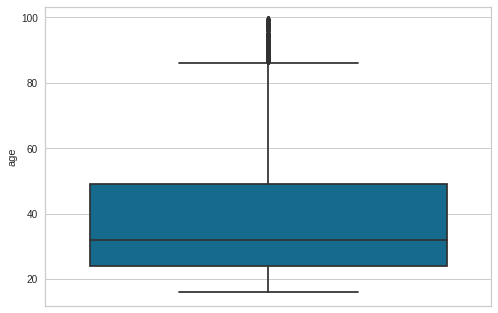

In [25]:
sns.boxplot(y = customers['age'])

Se observan dos segmentos de clientes, uno de ellos entre los 20 y 35 años y el restante entre los 45 años y 60 años. 

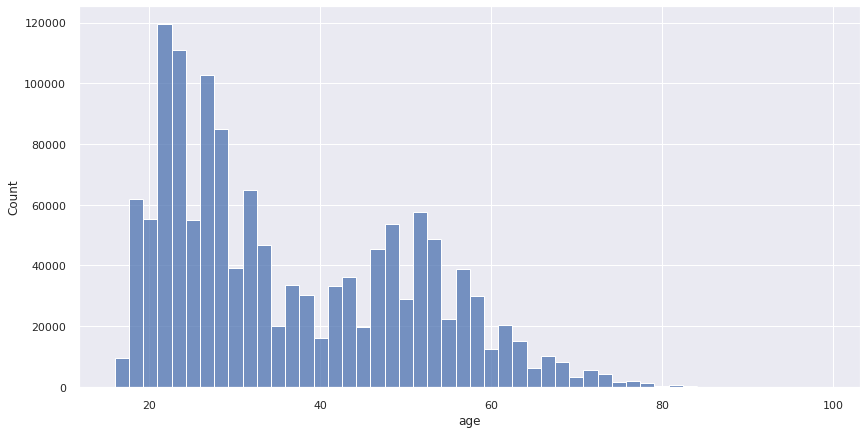

In [26]:
plt.figure(figsize=(14, 7))

sns.set(style="darkgrid")

sns.histplot(data=customers, x="age", bins=50)
plt.show()

In [27]:
articles.describe()

,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,garment_group_no
count,1.055420e+05,105542.000000,105542.000000,1.055420e+05,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000
mean,6.984246e+08,698424.563378,234.861875,1.009515e+06,32.233822,3.206183,7.807972,4532.777833,3.171534,42.664219,1010.438290
std,1.284624e+08,128462.384432,75.049308,2.241359e+04,28.086154,1.563839,5.376727,2712.692011,4.353234,23.260105,6.731023
min,1.087750e+08,108775.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,1201.000000,1.000000,2.000000,1001.000000
25%,6.169925e+08,616992.500000,252.000000,1.010008e+06,9.000000,2.000000,4.000000,1676.000000,1.000000,20.000000,1005.000000
50%,7.022130e+08,702213.000000,259.000000,1.010016e+06,14.000000,4.000000,5.000000,4222.000000,2.000000,46.000000,1009.000000
75%,7.967030e+08,796703.000000,272.000000,1.010016e+06,52.000000,4.000000,11.000000,7389.000000,4.000000,61.000000,1017.000000
max,9.594610e+08,959461.000000,762.000000,1.010029e+06,93.000000,7.000000,20.000000,9989.000000,26.000000,97.000000,1025.000000


In [28]:
articles.dtypes

article_id                       int64
product_code                     int64
prod_name                       object
product_type_no                  int64
product_type_name               object
product_group_name              object
graphical_appearance_no          int64
graphical_appearance_name       object
colour_group_code                int64
colour_group_name               object
perceived_colour_value_id        int64
perceived_colour_value_name     object
perceived_colour_master_id       int64
perceived_colour_master_name    object
department_no                    int64
department_name                 object
index_code                      object
index_name                      object
index_group_no                   int64
index_group_name                object
section_no                       int64
section_name                    object
garment_group_no                 int64
garment_group_name              object
detail_desc                     object
dtype: object

A continuación, se detalla la cantidad de articulos que se comercializan por tipo de clientes.

In [29]:
art = articles.groupby('index_group_name', as_index=False).agg(Cantidad=('article_id', 'count')).sort_values(by=['Cantidad'], ascending=False)
art

,index_group_name,Cantidad
2,Ladieswear,39737
0,Baby/Children,34711
1,Divided,15149
3,Menswear,12553
4,Sport,3392


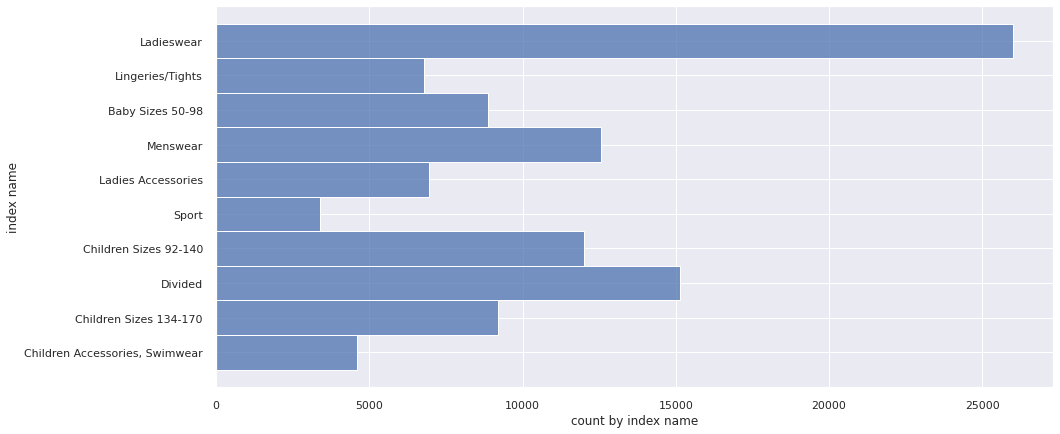

In [30]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='index_name')
ax.set_xlabel('count by index name')
ax.set_ylabel('index name')
plt.show()

### **3. Preparación de los Datos**

---



**Limpieza de Datos**

In [31]:
val_nulos(transactions)

,Missing Values
t_dat,0
customer_id,0
article_id,0
price,0
sales_channel_id,0
n_trans,0


In [32]:
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

Se evaluan los outliers en las precios de las transacciones. Se modifican aquellos valores que son considerados outliers, tomando el percentil 0.1 o 0.9.

In [33]:
#outliers(transactions)

En este caso, se analizo la cantidad de articulos comprados por cada cliente en el mismo dia. A partir de este valor, se analizo posiles outliers.

Para el caso de los outliers, se tomo el valor percentil 0.1 y 0.9 sin eliminar la transaccion por completo, ya que al no tener mayor información no era posible considerarla como un posible fraude. 

In [34]:
#outliers(trans_dia)

In [35]:
#n_trans = trans_dia['n_trans'].tolist()

#transactions = transactions[(transactions['n_trans'].isin(n_trans))]

In [36]:
val_nulos(customers)

,Missing Values
customer_id,0
FN,895050
Active,907576
club_member_status,6062
fashion_news_frequency,16009
age,15861
postal_code,0


In [37]:
customers['age']=customers['age'].fillna(customers['age'].mean())

In [38]:
customers['age'] = customers['age'].astype(np.int64)

In [39]:
customers['FN']=customers['FN'].fillna(0)
customers['Active']=customers['Active'].fillna(0)

In [40]:
val_nulos(articles)

,Missing Values
article_id,0
product_code,0
prod_name,0
product_type_no,0
product_type_name,0
product_group_name,0
graphical_appearance_no,0
graphical_appearance_name,0
colour_group_code,0
colour_group_name,0


In [41]:
aux1 = pd.merge(transactions[["customer_id", 'price', "sales_channel_id"]], customers[["customer_id",'age']])
aux1 = pd.DataFrame(aux1.groupby(['age', "sales_channel_id"], as_index=False).agg(ventas=('price', sum)))

# Create new dataframe column with the labels instead of numbers
aux1["sales_channel_id"] = aux1['sales_channel_id'].replace([1, 2], ['Store', 'Online'])
aux1.rename(columns={"sales_channel_id": "Canal Venta"}, inplace = True)
aux1['age'] = aux1['age'].astype('Int64', errors='ignore' )
aux1 = aux1[aux1.age < 70]

Se detallan las ventas por edad y canal de venta entre el año 2018 y 2020. Se observa que dos tercios de las ventas de los clientes entre los 20 y 40 años compran en forma online.

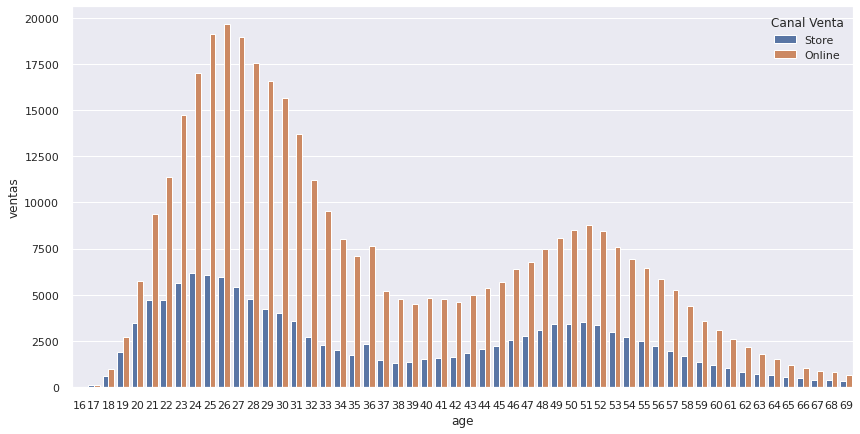

In [42]:
plt.figure(figsize=(14, 7))

bar1 = sns.barplot(x="age",  y="ventas", hue = 'Canal Venta', data=aux1, saturation=0.75, errcolor='.26')

plt.show()

In [43]:
aux2 = pd.merge(transactions[["article_id", 'price']], articles[["article_id",'index_group_name']])
aux2 = aux2.groupby('index_group_name', as_index=False).agg(ventas=('price', sum))

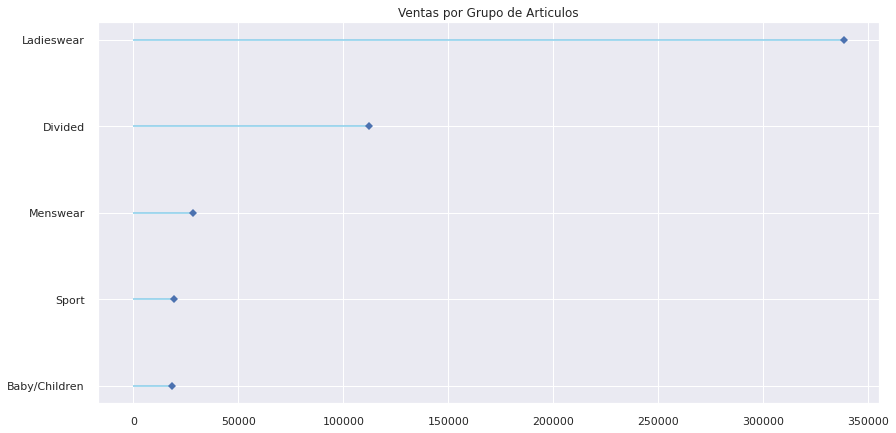

In [44]:
# Reorder it based on the values:
fig, ax = plt.subplots(figsize=(14,7))
ordered_df = aux2.sort_values(by='ventas')
my_range=range(1,len(aux2.index)+1)
 
# Horizontal version
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['ventas'], color='skyblue')
plt.plot(ordered_df['ventas'], my_range, "D")
plt.yticks(my_range, ordered_df['index_group_name'])
plt.title("Ventas por Grupo de Articulos")
plt.show()

In [45]:
aux3 = transactions.groupby(['t_dat', 'sales_channel_id'], as_index=False).agg(ventas=('price', sum))
aux3["sales_channel_id"] = aux3['sales_channel_id'].replace([1, 2], ['Store', 'Online'])

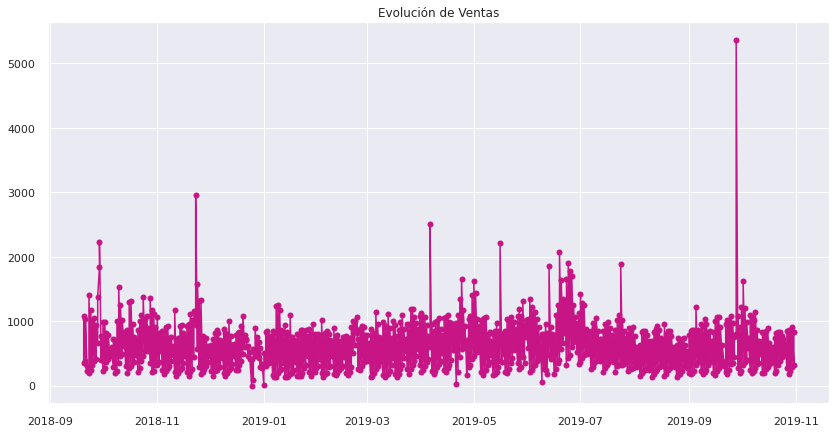

In [46]:
fig, ax = plt.subplots(figsize=(14,7))
plt.plot( 't_dat', 'ventas', data=aux3, marker='o', color='mediumvioletred')
plt.title("Evolución de Ventas")
plt.show()

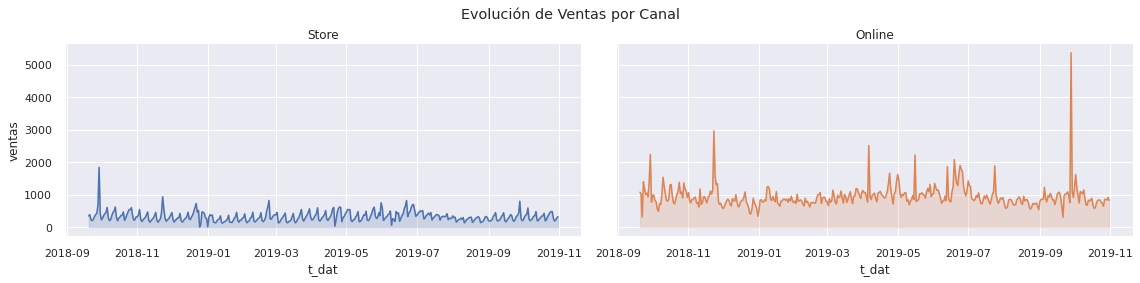

In [47]:
# Create a grid : initialize it
g = sns.FacetGrid(aux3, col='sales_channel_id', hue='sales_channel_id', col_wrap=2, height=4, aspect=2)

# Add the line over the area with the plot function
g = g.map(plt.plot, 't_dat', 'ventas')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 't_dat', 'ventas', alpha=0.2).set_titles("{col_name} Cluster")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
plt.subplots_adjust(top=0.85)
g = g.fig.suptitle('Evolución de Ventas por Canal')

# Show the graph
plt.show()

In [48]:
ventaspdia= transactions.groupby(['t_dat'], as_index=False).agg(ventas=('price', sum))
ventaspdia.sort_values(by ='ventas', ascending=False).head(15)

,t_dat,ventas
373,2019-09-28,6161.603068
9,2018-09-29,4071.381305
64,2018-11-23,3891.939441
198,2019-04-06,3100.904898
238,2019-05-16,2593.487271
272,2019-06-19,2476.714254
266,2019-06-13,2340.517932
277,2019-06-24,2332.485373
279,2019-06-26,2296.185915
278,2019-06-25,2251.667508


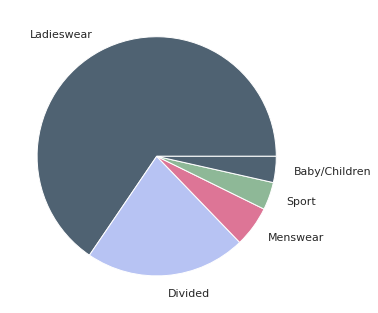

In [49]:
dfg = pd.merge(transactions[["article_id", 'price']], articles[['article_id','index_group_name']], on="article_id", how='inner')
dfg = dfg.groupby('index_group_name', as_index=False).agg(ventas=('price', sum), precio_promedio=('price', 'mean'))
dfg = dfg.sort_values(by = 'ventas', ascending=False).head(15)

# Create a set of colors
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']

# Use it thanks to the color argument
plt.pie(dfg.ventas, labels=dfg.index_group_name, labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);

In [50]:
dfg

,index_group_name,ventas,precio_promedio
2,Ladieswear,338189.077661,0.029122
1,Divided,112120.086051,0.026449
3,Menswear,28489.158034,0.028038
4,Sport,19338.326407,0.028570
0,Baby/Children,18220.176661,0.019241


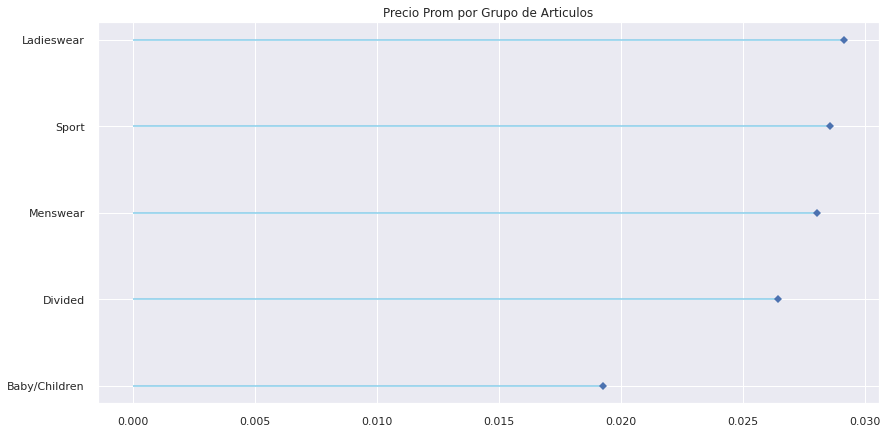

In [51]:
# Reorder it based on the values:
fig, ax = plt.subplots(figsize=(14,7))
ordered_df = dfg.sort_values(by='precio_promedio')
my_range=range(1,len(aux2.index)+1)
 
# Horizontal version
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['precio_promedio'], color='skyblue')
plt.plot(ordered_df['precio_promedio'], my_range, "D")
plt.yticks(my_range, ordered_df['index_group_name'])
plt.title("Precio Prom por Grupo de Articulos")
plt.show()

In [52]:
dfm = pd.merge(transactions[["article_id", 'price']], articles[['article_id','index_group_name', 'section_name']], on="article_id", how='inner')
dfm = dfm.groupby('section_name', as_index=False).agg(ventas=('price', sum))
dfm = dfm.sort_values(by = 'ventas', ascending=False).head(15)

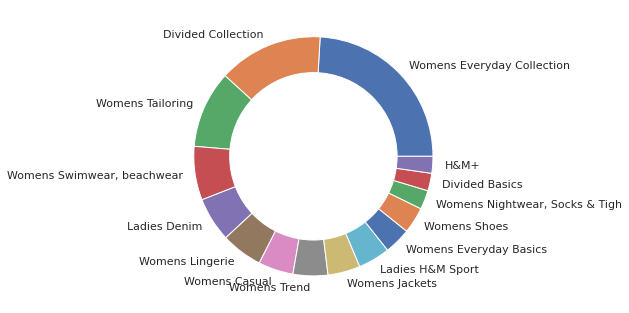

In [53]:
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

# Not enough colors --> colors will cycle
plt.pie(dfm["ventas"], labels=dfm["section_name"])
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.show()

**Construcción de Datos**

In [54]:
customers['club_member_status'] = customers['club_member_status'].replace({np.nan :0, 'PRE-CREATE':1, 'ACTIVE':2, 'LEFT CLUB':-1})

In [55]:
ohe = transactions.groupby(['customer_id','sales_channel_id'], as_index=False).agg(Cantidad=('n_trans', 'nunique'))

In [56]:
ohe = pd.pivot_table(ohe, values='Cantidad', index='customer_id', columns=['sales_channel_id'], fill_value=0)

In [57]:
ohe

sales_channel_id,1,2
customer_id,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,2,4
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,2,16
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0,3
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0,1
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,1,3
...,...,...
ffffa28cd7ab5d1cbbbfe7b582b1c419270cc0539f3dae5bdfa4cf4b5874c806,1,0
ffffaff3905b803d1c7e153a1378a5151e1f34f236ba5451afc7cf3f699c5690,1,0
ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e4747568cac33e8c541831,1,2


In [58]:
df = transactions.groupby('customer_id').agg(
    precio_promedio=('price', 'mean'),
    compras_totales=('price', sum),
    cantidad_compras=('t_dat', 'nunique'),
    # Get max of the duration column for each group
    #fecha_ultima_compra=('t_dat', max),
    # Get min of the duration column for each group
    #fecha_primer_compra=('t_dat', min),
    # Apply a lambda to date column
    antiguedad=("t_dat", lambda x: (max(x) - min(x)).days) 
)

In [59]:
df['promedio_dias_compra'] = transactions['previous_visit'] = transactions.groupby(['customer_id'])['t_dat'].shift()
df['promedio_dias_compra'] = transactions['days_bw_visits'] = transactions['t_dat'] - transactions['previous_visit']
df['promedio_dias_compra'] = transactions['days_bw_visits'] = transactions['days_bw_visits'].apply(lambda x: x.days)
df['promedio_dias_compra'] = transactions.groupby('customer_id')['days_bw_visits'].agg('mean')

df = pd.merge(df, customers[['customer_id','Active','FN' ,'age', 'club_member_status']], on="customer_id", how = 'left')
df['unica_compra'] = np.where(df['cantidad_compras'] == 1, '1', '0')
#df.fillna(axis=1).fillna(0)


In [60]:
df['promedio_dias_compra'].mean()

14.231833653833714

In [61]:
df = pd.merge(df, ohe, on="customer_id", how='left')

#df.fillna(0)

In [62]:
df.rename(columns={1: "Store", 2: "Online"},inplace=True,)

In [ ]:
#dias_ult_compra = transactions.groupby('customer_id', as_index=False).agg(Cantidad=('t_dat', 'max'))
#import datetime   
#max_date = datetime.datetime(2020, 9, 22) 
#dias_ult_compra['dias'] = max_date - dias_ult_compra['Cantidad']
#dias_ult_compra['dias'] = dias_ult_compra['dias'].dt.days

In [ ]:
#df = pd.merge(df, dias_ult_compra[['customer_id', 'dias']], on="customer_id", how='inner')

In [64]:
df

,customer_id,precio_promedio,compras_totales,cantidad_compras,antiguedad,promedio_dias_compra,Active,FN,age,club_member_status,unica_compra,Store,Online
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.037117,0.408288,6,275,27.500000,0.0,0.0,49,2,0,2,4
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.033947,1.765220,17,398,7.803922,0.0,0.0,25,2,0,2,16
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.036424,0.145695,3,162,54.000000,0.0,0.0,24,2,0,0,3
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.030492,0.060983,1,0,0.000000,0.0,0.0,54,2,1,0,1
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0.035647,0.213881,4,362,72.400000,1.0,1.0,52,2,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049302,ffffa28cd7ab5d1cbbbfe7b582b1c419270cc0539f3dae...,0.029367,0.088102,1,0,0.000000,1.0,1.0,22,2,1,1,0
1049303,ffffaff3905b803d1c7e153a1378a5151e1f34f236ba54...,0.122017,0.122017,1,0,NaN,1.0,1.0,21,2,1,1,0
1049304,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0.028576,0.657237,3,53,2.409091,0.0,0.0,24,2,0,1,2
1049305,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0.020758,0.726525,8,379,11.147059,0.0,0.0,21,2,0,5,3


In [63]:
val_nulos(df)

,Missing Values
customer_id,0
precio_promedio,0
compras_totales,0
cantidad_compras,0
antiguedad,0
promedio_dias_compra,103154
Active,0
FN,0
age,0
club_member_status,0


In [64]:
df['promedio_dias_compra'] = df['promedio_dias_compra'].fillna(df['promedio_dias_compra'].mean())

In [61]:
#temp = pd.merge(transactions[["customer_id", "article_id"]], articles[['article_id','index_group_name']], on="article_id", how='inner')
#temp = temp.dropna()
#ca_matrix = pd.crosstab(index=temp.customer_id, columns=temp.index_group_name)
#ca_matrix = pd.DataFrame(ca_matrix)

In [65]:
# selecting numerical columns
num_cols = df[['precio_promedio', 'compras_totales','promedio_dias_compra','Active', 'club_member_status' ,'age','Store','Online', 'unica_compra', 'antiguedad']]
#num_cols = df8.select_dtypes(include=np.number).columns.tolist()

*Precio promedio*

<AxesSubplot:xlabel='precio_promedio'>

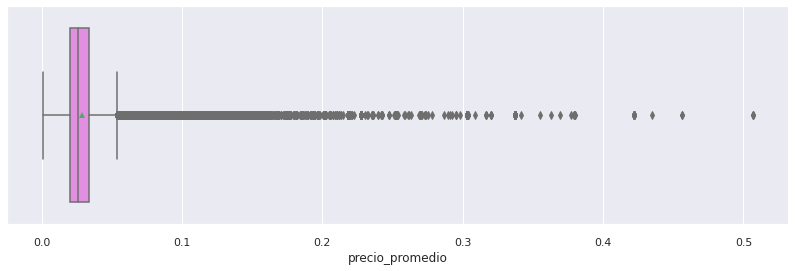

In [66]:
plt.figure(figsize=(14, 4))
sns.boxplot(data=df, x="precio_promedio", showmeans=True, color="violet")

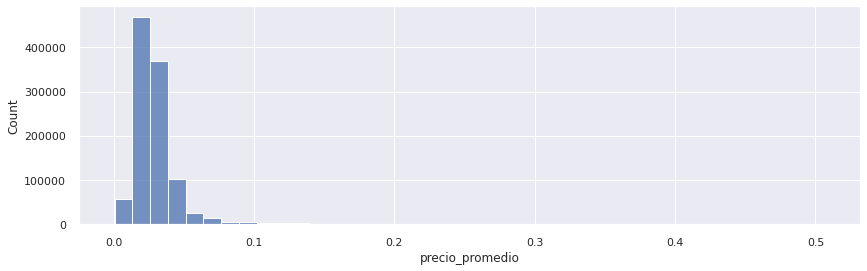

In [67]:
plt.figure(figsize=(14, 4))
sns.set(style="darkgrid")
sns.histplot(data=df, x="precio_promedio", bins=40)
plt.show()

In [68]:
for x in ['precio_promedio']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan


*Gasto Total*

<AxesSubplot:xlabel='compras_totales'>

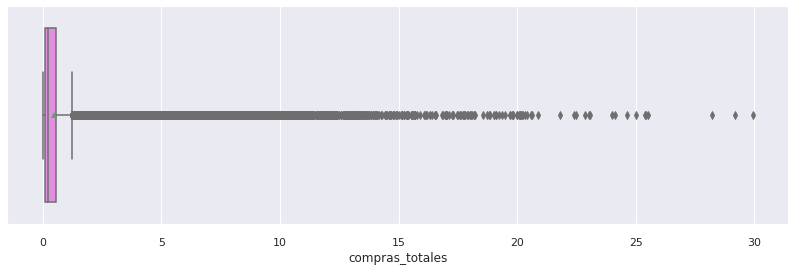

In [69]:
plt.figure(figsize=(14, 4))
sns.boxplot(data=df, x="compras_totales", showmeans=True, color="violet")

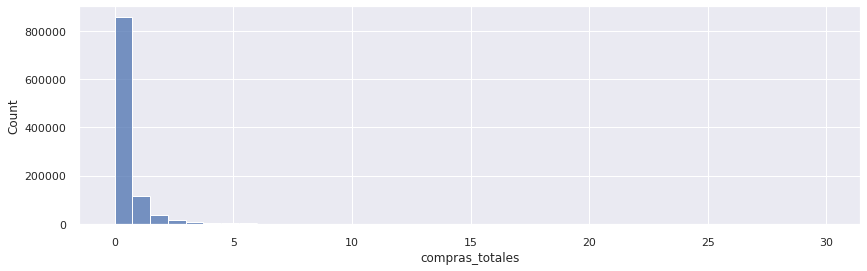

In [70]:
plt.figure(figsize=(14, 4))
sns.set(style="darkgrid")
sns.histplot(data=df, x="compras_totales", bins=40)
plt.show()

In [71]:
for x in ['compras_totales']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan

*Promedio de dias entre cada compra*

<AxesSubplot:xlabel='promedio_dias_compra'>

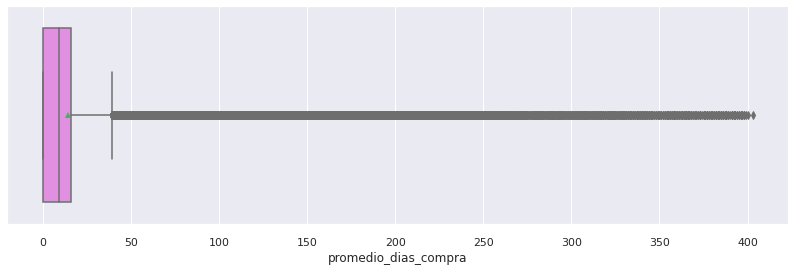

In [72]:
plt.figure(figsize=(14, 4))
sns.boxplot(data=df, x="promedio_dias_compra", showmeans=True, color="violet")

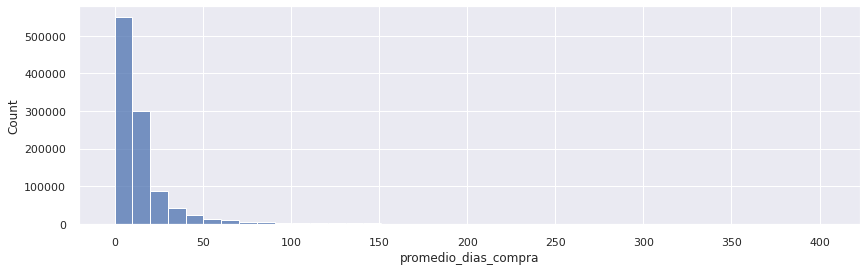

In [73]:
plt.figure(figsize=(14, 4))
sns.set(style="darkgrid")
sns.histplot(data=df, x="promedio_dias_compra", bins=40)
plt.show()

In [74]:
for x in ['promedio_dias_compra']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan

*Cantidad de Compras en Tienda*

<AxesSubplot:xlabel='Store'>

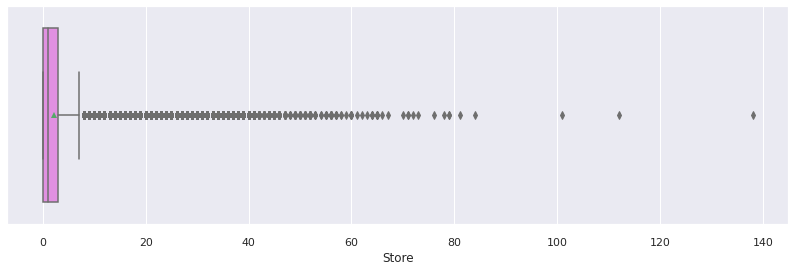

In [75]:
plt.figure(figsize=(14, 4))
sns.boxplot(data=df, x="Store", showmeans=True, color="violet")

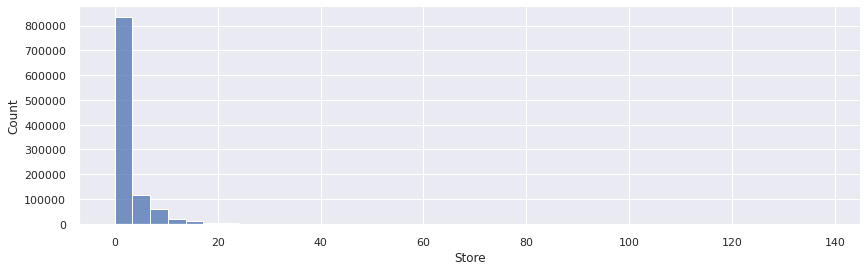

In [76]:
plt.figure(figsize=(14, 4))
sns.set(style="darkgrid")
sns.histplot(data=df, x="Store", bins=40)
plt.show()

In [77]:
for x in ['Store']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan

*Cantidad de compras Online*

<AxesSubplot:xlabel='Online'>

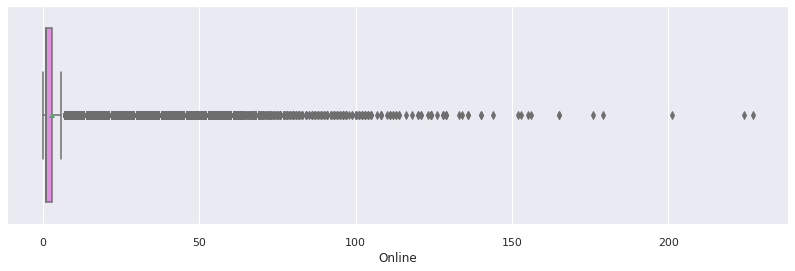

In [78]:
plt.figure(figsize=(14, 4))
sns.boxplot(data=df, x="Online", showmeans=True, color="violet")

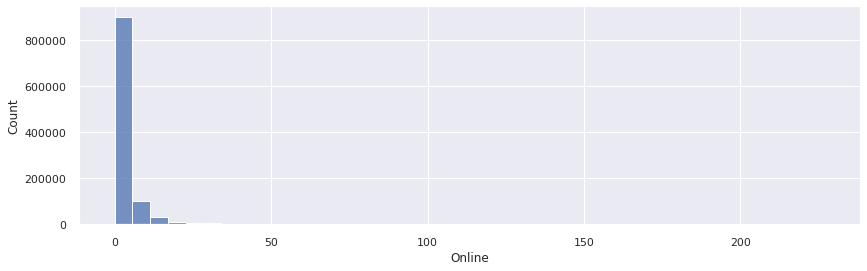

In [79]:
plt.figure(figsize=(14, 4))
sns.set(style="darkgrid")
sns.histplot(data=df, x="Online", bins=40)
plt.show()

In [80]:
for x in ['Online']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan

*Antiguedad*

<AxesSubplot:xlabel='antiguedad'>

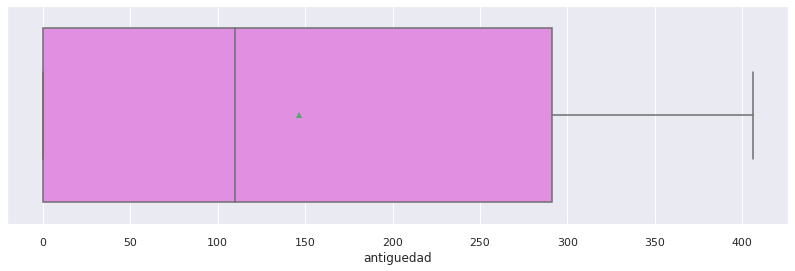

In [81]:
plt.figure(figsize=(14, 4))
sns.boxplot(data=df, x="antiguedad", showmeans=True, color="violet")

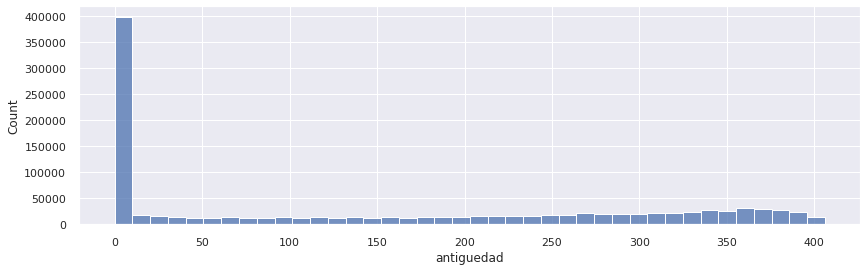

In [82]:
plt.figure(figsize=(14, 4))
sns.set(style="darkgrid")
sns.histplot(data=df, x="antiguedad", bins=40)
plt.show()

In [83]:
for x in ['antiguedad']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan

*Age*

<AxesSubplot:xlabel='age'>

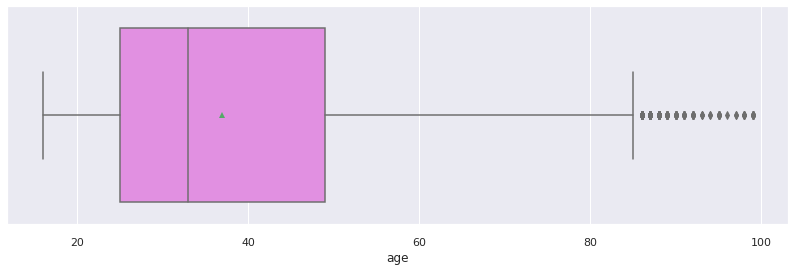

In [84]:
plt.figure(figsize=(14, 4))
sns.boxplot(data=df, x="age", showmeans=True, color="violet")

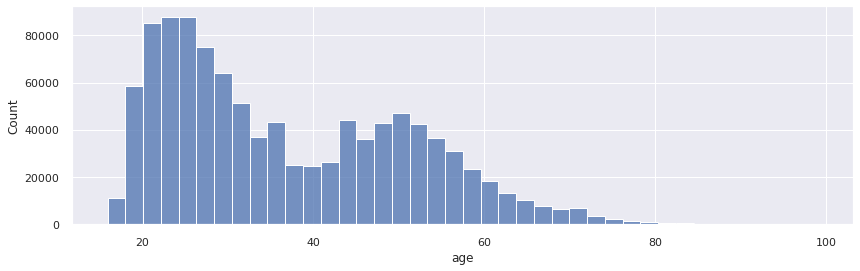

In [85]:
plt.figure(figsize=(14, 4))
sns.set(style="darkgrid")
sns.histplot(data=df, x="age", bins=40)
plt.show()

In [86]:
for x in ['age']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan

In [87]:
df.shape

(1049307, 13)

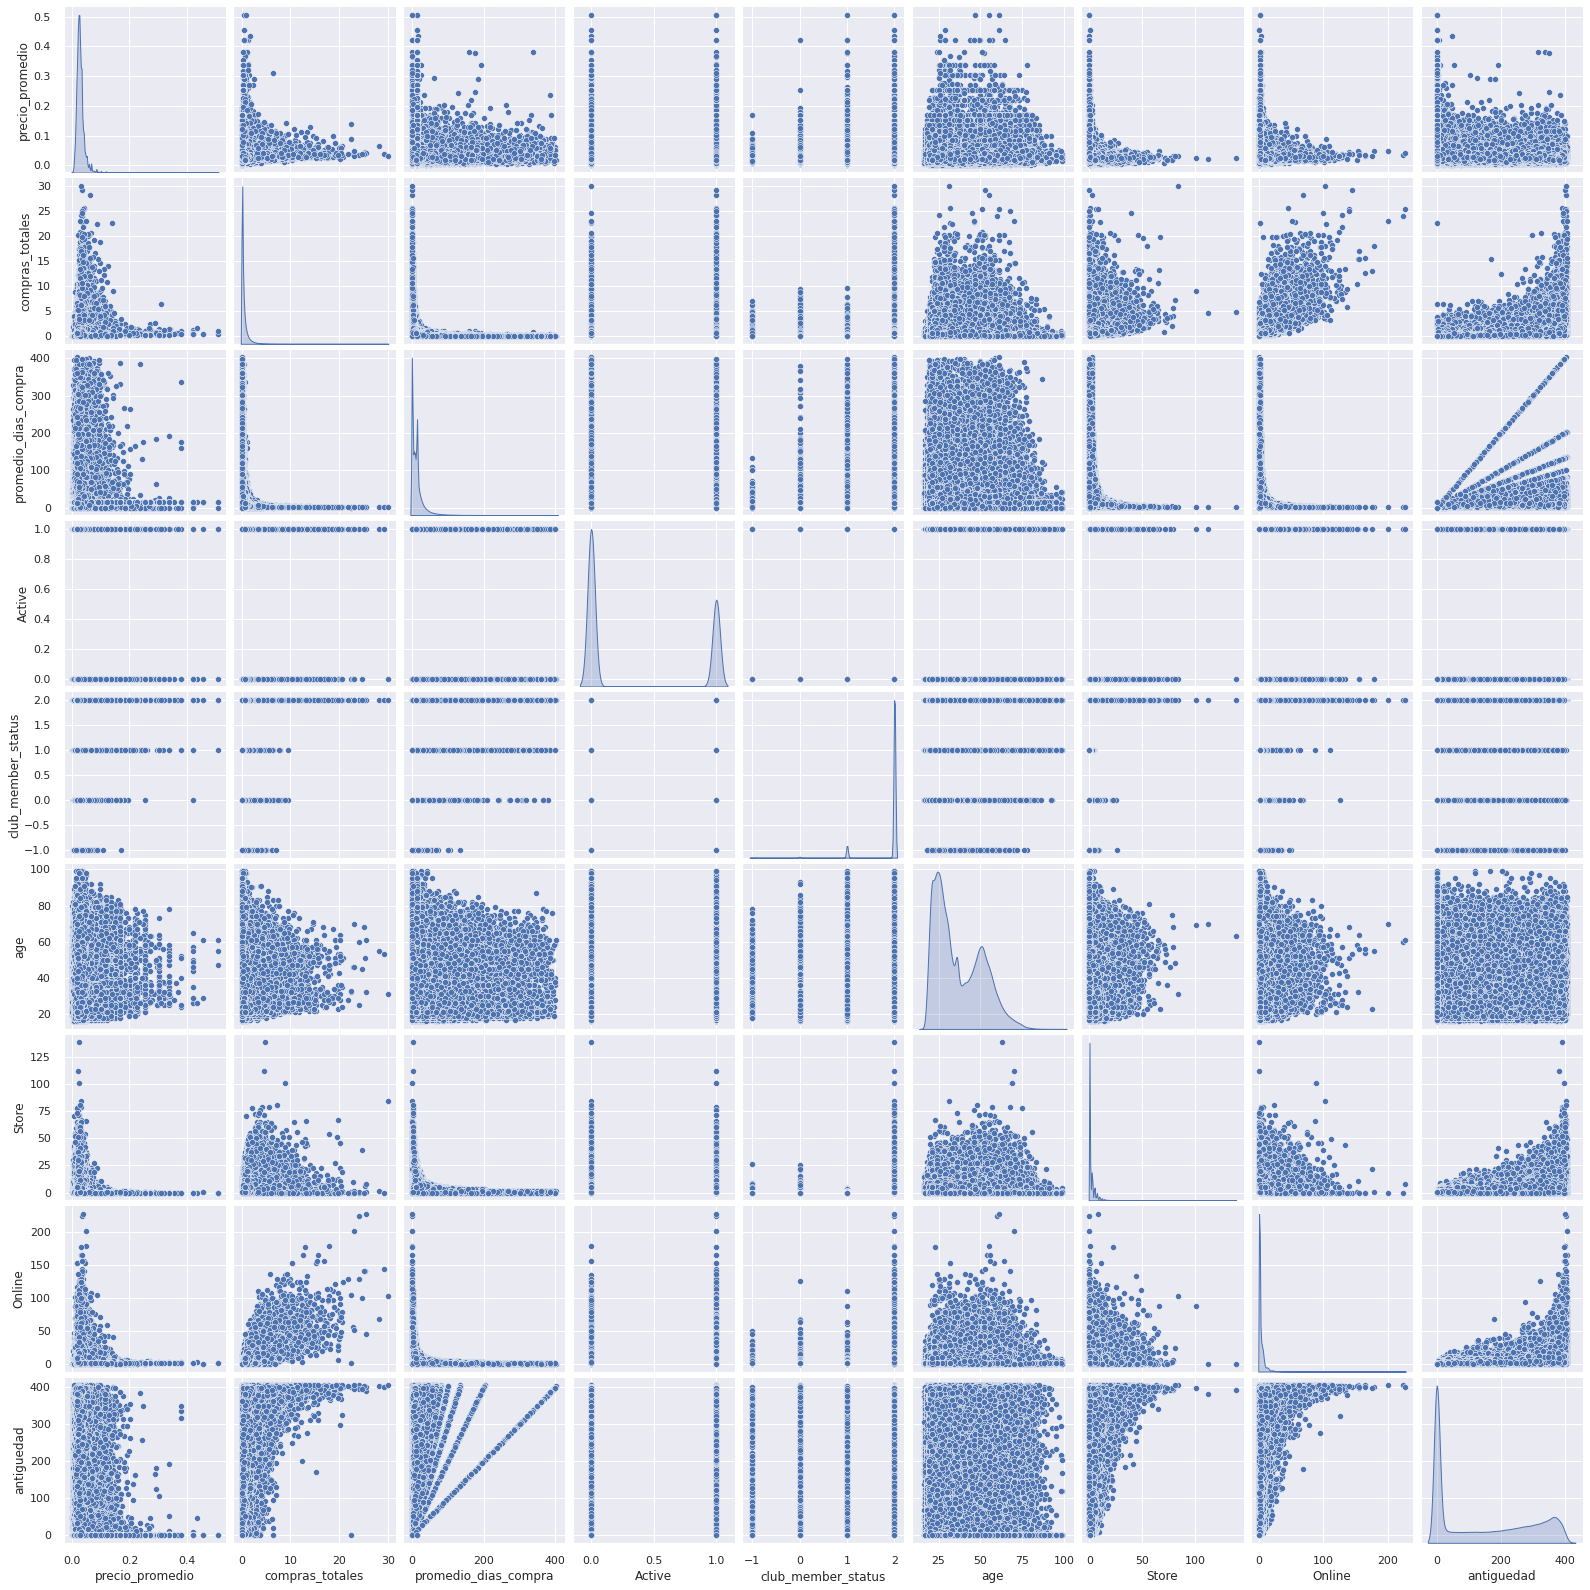

In [88]:
sns.pairplot(num_cols,diag_kind="kde")

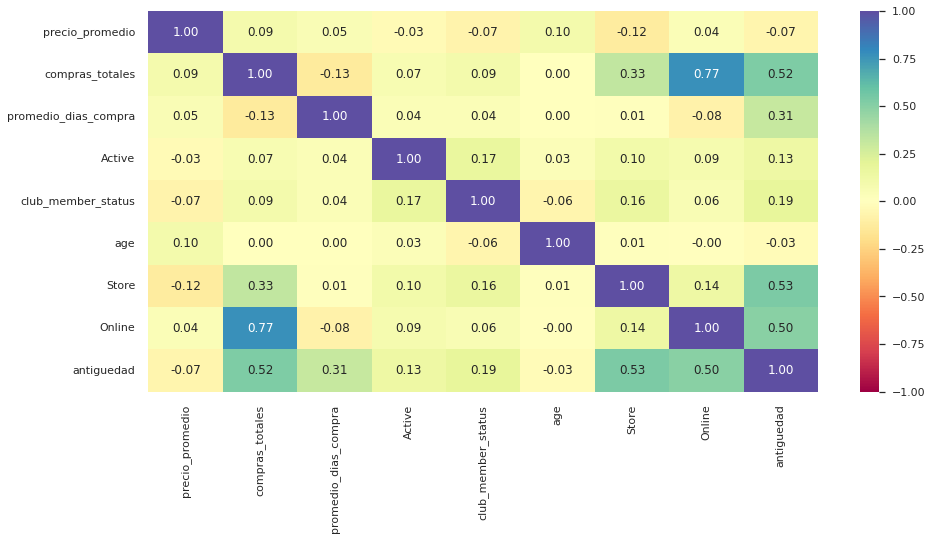

In [89]:
# check for correlations

plt.figure(figsize=(15, 7))
sns.heatmap(
    num_cols.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

In [ ]:
#df['promedio_dias_compra'].replace(to_replace = 0, value = df['promedio_dias_compra'].mean(), inplace=True)

# **4. Modelado**

---



In [90]:
dfcluster = num_cols
dfcluster = dfcluster.fillna(0)
#outliers(dfcluster)

In [91]:
scaler = StandardScaler()
dfcluster = scaler.fit_transform(dfcluster)

In [92]:
from pyclustertend import hopkins
hopkins(dfcluster,150)

0.005051935496887869

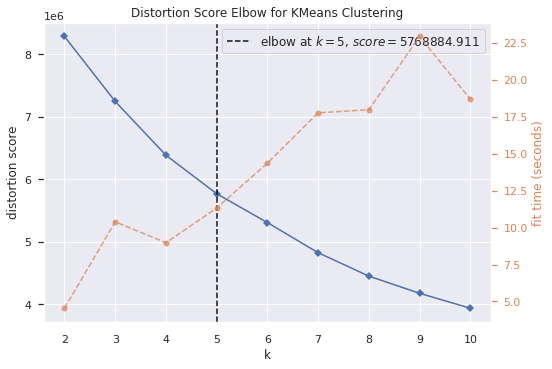

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [93]:
kmeanModel = KMeans()
elb_visualizer = KElbowVisualizer(kmeanModel, k=(2,11))
elb_visualizer.fit(dfcluster)    
elb_visualizer.show() 

In [94]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(dfcluster)
predict=kmeans.predict(dfcluster)

In [ ]:
visualizer = SilhouetteVisualizer(KMeans(5, random_state = 1))
visualizer.fit(dfcluster)    
visualizer.show();

KeyboardInterrupt: ignored

In [ ]:
from yellowbrick.cluster import silhouette_visualizer
silhouette_visualizer(KMeans(5, random_state=42), dfcluster, colors='yellowbrick')

KeyboardInterrupt: ignored

In [95]:
#df = df.dropna()
df["Cluster"] = kmeans.labels_

In [96]:
results = df.groupby(['Cluster'], as_index = False).agg(
    Cantidad=('customer_id', 'count'),    
    precio_promedio=('precio_promedio', 'mean'),
    compras_totales=('compras_totales', sum),    
    antiguedad=('antiguedad', 'mean'),
    #min_antiguedad=('antiguedad', 'min'),
    #max_antiguedad=('antiguedad', 'max'),    
    promedio_dias_compras=('promedio_dias_compra', 'mean'),  
    age=('age', 'mean'),
    #store=('Store', 'mean'),
    #online=('Online', 'mean'),
    #baby_children=('Baby/Children', 'mean'),
    #Ladieswear	=('Ladieswear', 'mean'),  
    #Menswear=('Menswear', 'mean'),
    #Divided=('Divided', 'mean'),
    club_member_status=('club_member_status', 'mean'),    
    Active=('Active', 'mean'), 
    Store =('Store', 'mean'),  
    Online =('Online', 'mean'), 
    unica_compra =('unica_compra', 'mean')
)

In [97]:
results

,Cluster,Cantidad,precio_promedio,compras_totales,antiguedad,promedio_dias_compras,age,club_member_status,Active,Store,Online,unica_compra
0,0,355995,0.026485,134514.103797,207.963089,13.562206,35.862297,1.999640,0.000000,1.961392,2.070885,0.0
1,1,241282,0.026077,92590.618661,222.377716,14.192113,36.946700,1.999801,1.000000,2.141383,2.113960,0.0
2,2,62437,0.030802,3772.901051,358.567180,4.831500,37.609719,1.995996,0.462979,2.284017,4.487723,inf
3,3,311230,0.025965,29771.636847,0.005661,4.013379,37.072719,2.000000,0.314796,0.390104,0.613826,inf
4,4,78363,0.028396,13224.214644,45.629723,6.564651,40.326248,0.920830,0.058918,0.015141,1.536215,inf


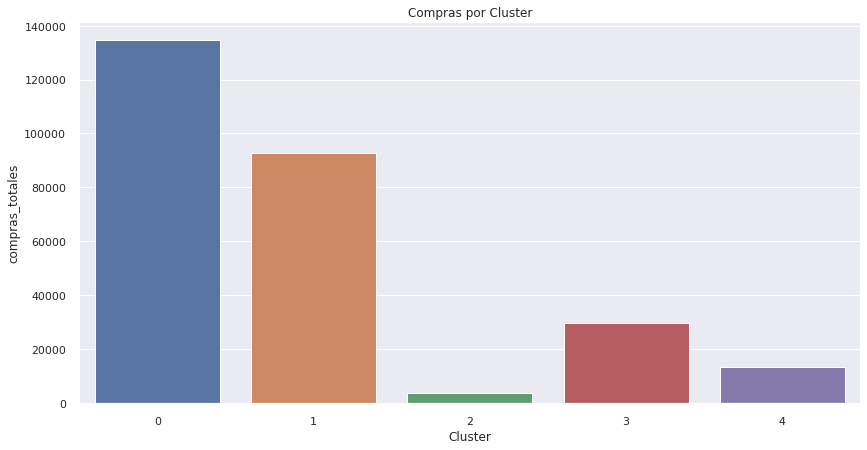

In [98]:
plt.figure(figsize = (14,7))
sns.set_color_codes("pastel")
sns.barplot(x = 'Cluster', y="compras_totales", data=results)
plt.title(f'Compras por Cluster')
plt.show()

# **5. Insights**

---



**Analisis Exploratorio**



*   Se observa que las ventas online son mayores a las ventas en los locales comerciales. Ademas, se visualiza que un aumento en las ventas online en el año 2020 comparado al 2019 a causa del COVID 19. Esto se sustenta en la falta de ventas en store en el mes de abril 2020.
Por otra parte, las ventas en los locales comerciales se observan constantes en todo momento del año, observandose los picos de ventas en el canal online.

*   Se observa los 15 dias de mayor ventas, siendo dos de estos el dia del trabajo y de accion de gracias. 

*   La edad de los clientes esta mayormente segmentado entre los 20 y 40 años. En este segmento, las ventas son principalmente en forma online. De alli en mas, la proporción de ventas por canales se equilibra.

*   El catalogo de productos de la empresa comercializa principalmente articulos para mujeres y niños. Las ventas de productos para mujeres se encuentran en el 63% de las ventas totales.



**Clustering**


*   Cluster 0 - El segmento de clientes con mas ventas asi como el cluster con mayor cantidad de clientes. No tiene comunicación activa con la empresa. Realiza compras en forma continua. Prefiere la compra online sobre la presencial.


*   Cluster 1 - Es el segundo cluster con mas cantidad de ventas. Similar al cluster anterior, con la diferencia que no diferencia entre las compras online o presencial. Esto esta relacionado a que es activo en comunicaciones con la empresa.

*   Cluster 2 - Es el segmento de clientes con menor cantidad de ventas y clientes. Realizan compras de manera espontanea.

*   Cluster 3 - Clientes a recuperar.

*   Cluster 4 - Clientes a recuperar. Compran mas seguido que el cluster anterior pero muy especificamente.


In [ ]:
aux5 = pd.merge(transactions[["customer_id", 't_dat', 'article_id' ,'price']], df[["customer_id",'Cluster']], on="customer_id", how='inner')
aux5 = pd.merge(aux5, articles[['article_id','index_group_name', 'section_name']], on="article_id", how='inner')
aux1 = aux5.groupby(['t_dat', 'Cluster'], as_index=False).agg(ventas=('price', sum))

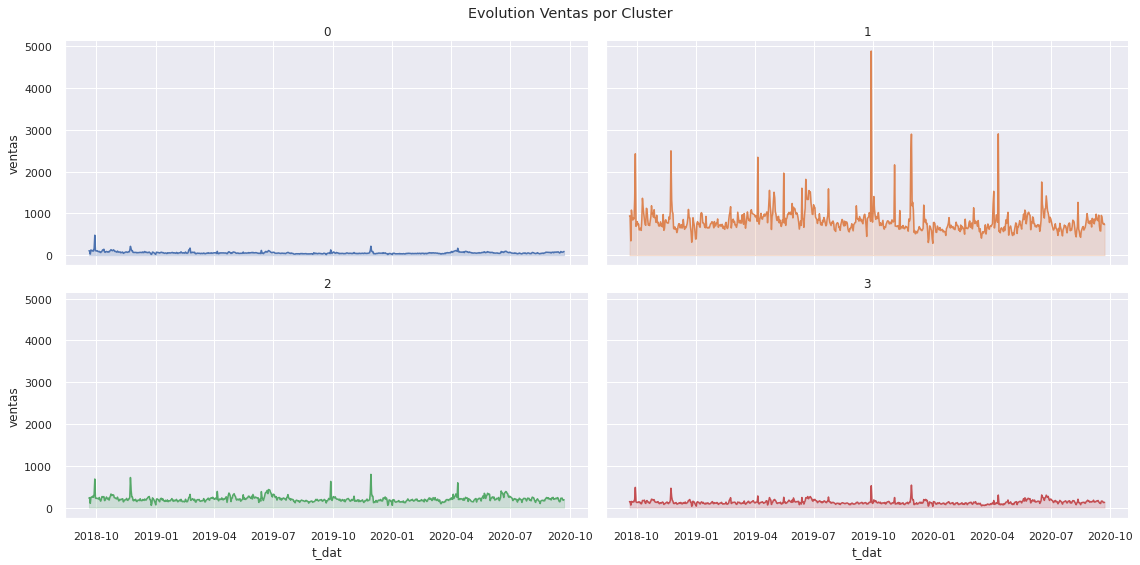

In [ ]:
# Create a grid : initialize it
g = sns.FacetGrid(aux1, col='Cluster', hue='Cluster', col_wrap=2, height=4, aspect=2)

# Add the line over the area with the plot function
g = g.map(plt.plot, 't_dat', 'ventas')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 't_dat', 'ventas', alpha=0.2).set_titles("{col_name} Cluster")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('Evolution Ventas por Cluster')

# Show the graph
plt.show()

**Cluster 0**  

In [ ]:
dfm = pd.merge(transactions[["article_id", 'price']], articles[['article_id','index_group_name', 'section_name', 'product_group_name']], on="article_id", how='inner')
dfm = dfm.groupby('product_group_name', as_index=False).agg(ventas=('price', sum))
dfm = dfm.sort_values(by = 'ventas', ascending=False).head(15)

In [ ]:
cluster0 = aux5[aux5['Cluster']==0]

In [ ]:
cluster0

,customer_id,t_dat,article_id,price,Cluster,index_group_name,section_name
38,3db0fe84a7ecb76afe21a0afc575d05fbd3a87592cc13d...,2018-09-21,663713001,0.050831,0,Ladieswear,Womens Lingerie
74,58c0eef0fd9f243f5e26983209b376f17f9355f38842bd...,2018-09-23,663713001,0.050831,0,Ladieswear,Womens Lingerie
138,818842570bc61a1060e54afed65de6df7fb586bdece05e...,2018-09-26,663713001,0.050831,0,Ladieswear,Womens Lingerie
139,818842570bc61a1060e54afed65de6df7fb586bdece05e...,2018-09-26,663713001,0.050831,0,Ladieswear,Womens Lingerie
143,a498425dda47335061591e8d9d76d704c0c1b0c0d606af...,2018-09-26,663713001,0.050831,0,Ladieswear,Womens Lingerie
...,...,...,...,...,...,...,...
31788319,39e3a68996f1b02fc97157c978e23bf5ada4b43541ef8b...,2020-09-22,886270008,0.045746,0,Divided,Divided Complements Other
31788320,39e3a68996f1b02fc97157c978e23bf5ada4b43541ef8b...,2020-09-22,886270008,0.045746,0,Divided,Divided Complements Other
31788321,ec794d6268ee3c75b5bbea014e3299d994bcd1180ecf6d...,2020-09-22,860135008,0.038119,0,Menswear,Contemporary Casual
31788322,ec794d6268ee3c75b5bbea014e3299d994bcd1180ecf6d...,2020-09-22,539060028,0.016017,0,Baby/Children,Boys Underwear & Basics


In [ ]:
dfm = aux5.groupby(['section_name', 'Cluster'], as_index=False).agg(ventas=('price', sum))

In [ ]:
dfm

,section_name,Cluster,ventas
0,Baby Boy,0,79.889288
1,Baby Boy,1,46.648051
2,Baby Boy,2,203.163220
3,Baby Boy,3,515.854492
4,Baby Boy,4,176.814068
...,...,...,...
275,Young Girl,0,326.386644
276,Young Girl,1,173.658898
277,Young Girl,2,652.171458
278,Young Girl,3,2104.132034


In [ ]:
dfart = aux5.groupby(['Cluster', 'article_id'], as_index=False).agg(ventas=('price', sum))

In [ ]:
dfart0 = dfart[dfart['Cluster']==0].head(15)
dfart0.sort_values(by = 'ventas', ascending=False).head(15)

,Cluster,article_id,ventas
9,0,111593001,12.190508
8,0,111586001,10.354678
0,0,108775015,8.457610
1,0,108775044,5.143542
6,0,111565001,3.346797
10,0,111609001,3.050763
3,0,110065001,1.818593
5,0,110065011,1.504390
4,0,110065002,1.062881
14,0,118458004,0.625068


In [ ]:
dfart1 = dfart[dfart['Cluster']==1].head(15)
dfart1.sort_values(by = 'ventas', ascending=False).head(15)

,Cluster,article_id,ventas
80451,1,111593001,2.230729
80443,1,108775015,1.698271
80450,1,111586001,1.603627
80444,1,108775044,1.174220
80452,1,111609001,0.686763
80449,1,111565001,0.460000
80455,1,118458004,0.425203
80448,1,110065011,0.384051
80446,1,110065001,0.379000
80447,1,110065002,0.227729


In [ ]:
dfart2 = dfart[dfart['Cluster']==2].head(15)
dfart2.sort_values(by = 'ventas', ascending=False).head(15)

,Cluster,article_id,ventas
149489,2,108775015,14.566695
149498,2,111593001,12.669407
149497,2,111586001,11.852492
149490,2,108775044,9.456508
149495,2,111565001,4.970712
149499,2,111609001,4.283237
149492,2,110065001,1.922593
149494,2,110065011,1.689085
149493,2,110065002,1.135085
149503,2,114428030,0.218966


In [ ]:
dfart4 = dfart[dfart['Cluster']==4].head(15)
dfart4.sort_values(by = 'ventas', ascending=False).head(15)

,Cluster,article_id,ventas
334569,4,111586001,73.266831
334570,4,111593001,63.567678
334561,4,108775015,13.150085
334562,4,108775044,9.986119
334571,4,111609001,8.282322
334567,4,111565001,8.125678
334564,4,110065001,5.734373
334566,4,110065011,5.210983
334565,4,110065002,1.728271
334575,4,116379047,0.253356


In [ ]:
dfmcluster0 = dfm[dfm['Cluster']==0].head(15)

# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

# Not enough colors --> colors will cycle
plt.pie(dfmcluster0["ventas"], labels=dfmcluster0["section_name"])
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.show()

KeyError: ignored

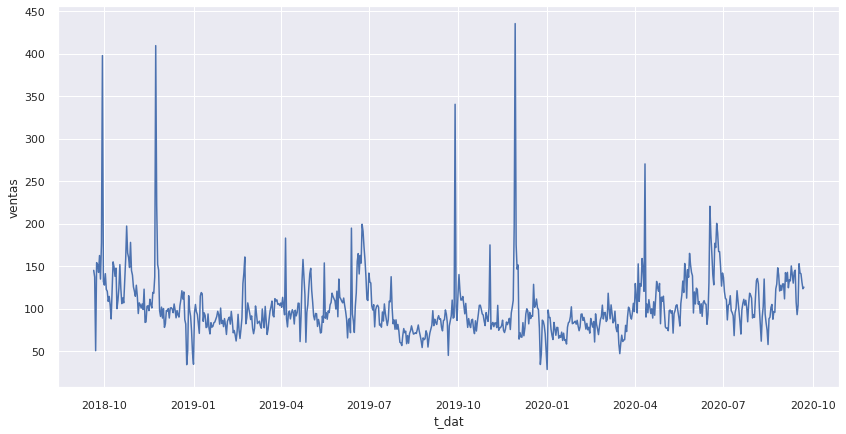

In [ ]:
aux5cluster0 = aux1[aux1['Cluster']==0]
fig, ax = plt.subplots(figsize=(14,7))

# multiple line plots
sns.lineplot(data=aux5cluster0, x='t_dat', y='ventas')

# show graph
plt.show()

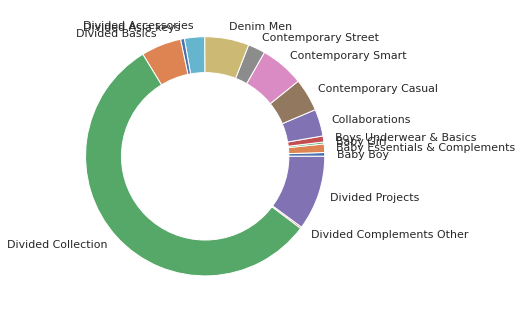

In [ ]:
dfmcluster1 = dfm[dfm['Cluster']==1].head(15)

# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

# Not enough colors --> colors will cycle
plt.pie(dfmcluster1["ventas"], labels=dfmcluster1["section_name"])
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.show()

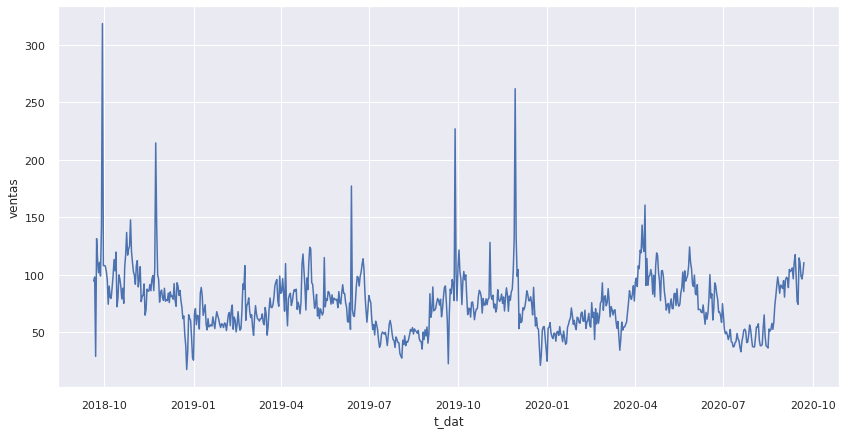

In [ ]:
aux5cluster1 = aux5[aux5['Cluster']==1]
fig, ax = plt.subplots(figsize=(14,7))

# multiple line plots
sns.lineplot(data=aux5cluster1, x='t_dat', y='ventas')

# show graph
plt.show()

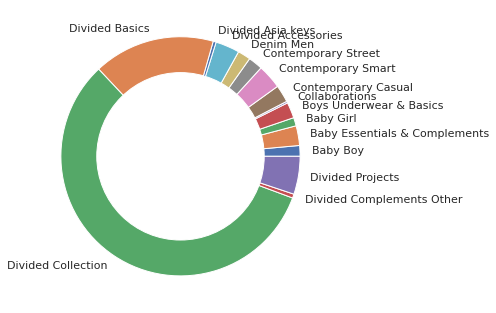

In [ ]:
dfmcluster2 = dfm[dfm['Cluster']==2].head(15)

# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

# Not enough colors --> colors will cycle
plt.pie(dfmcluster2["ventas"], labels=dfmcluster2["section_name"])
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.show()

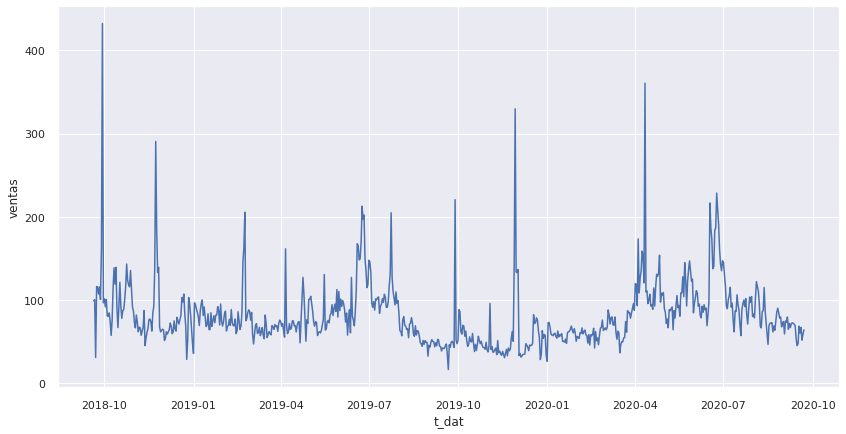

In [ ]:
aux5cluster2 = aux5[aux5['Cluster']==2]
fig, ax = plt.subplots(figsize=(14,7))

# multiple line plots
sns.lineplot(data=aux5cluster2, x='t_dat', y='ventas')

# show graph
plt.show()

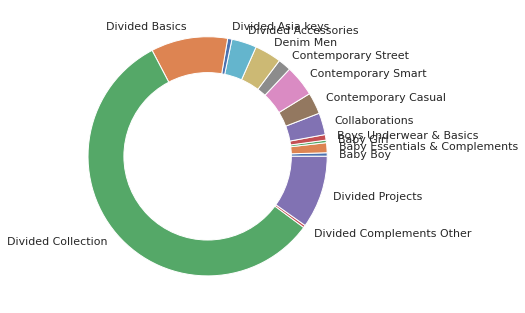

In [ ]:
dfmcluster3 = dfm[dfm['Cluster']==3].head(15)

# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

# Not enough colors --> colors will cycle
plt.pie(dfmcluster3["ventas"], labels=dfmcluster3["section_name"])
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.show()

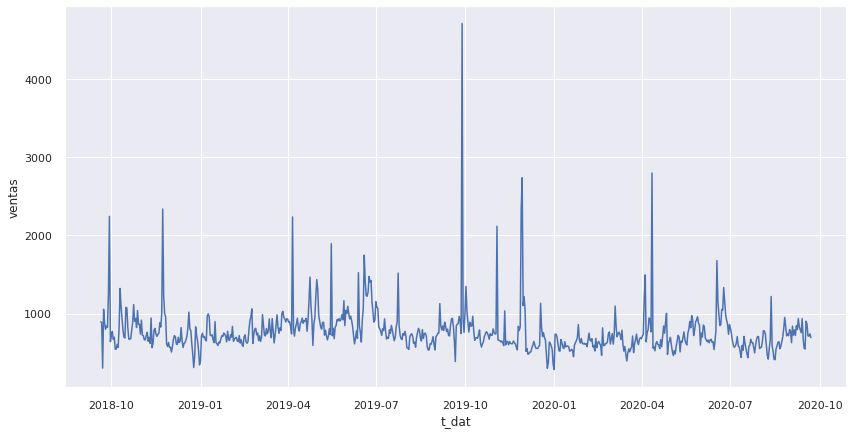

In [ ]:
aux5cluster3 = aux5[aux5['Cluster']==3]
fig, ax = plt.subplots(figsize=(14,7))

# multiple line plots
sns.lineplot(data=aux5cluster3, x='t_dat', y='ventas')

# show graph
plt.show()

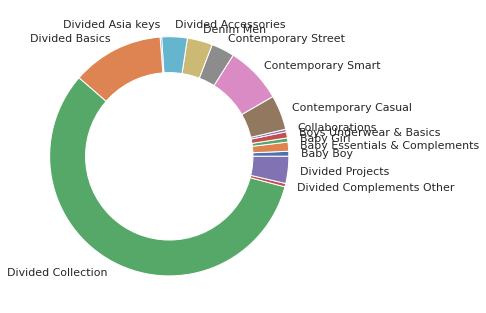

In [ ]:
dfmcluster4 = dfm[dfm['Cluster']==4].head(15)

# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

# Not enough colors --> colors will cycle
plt.pie(dfmcluster4["ventas"], labels=dfmcluster4["section_name"])
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.show()

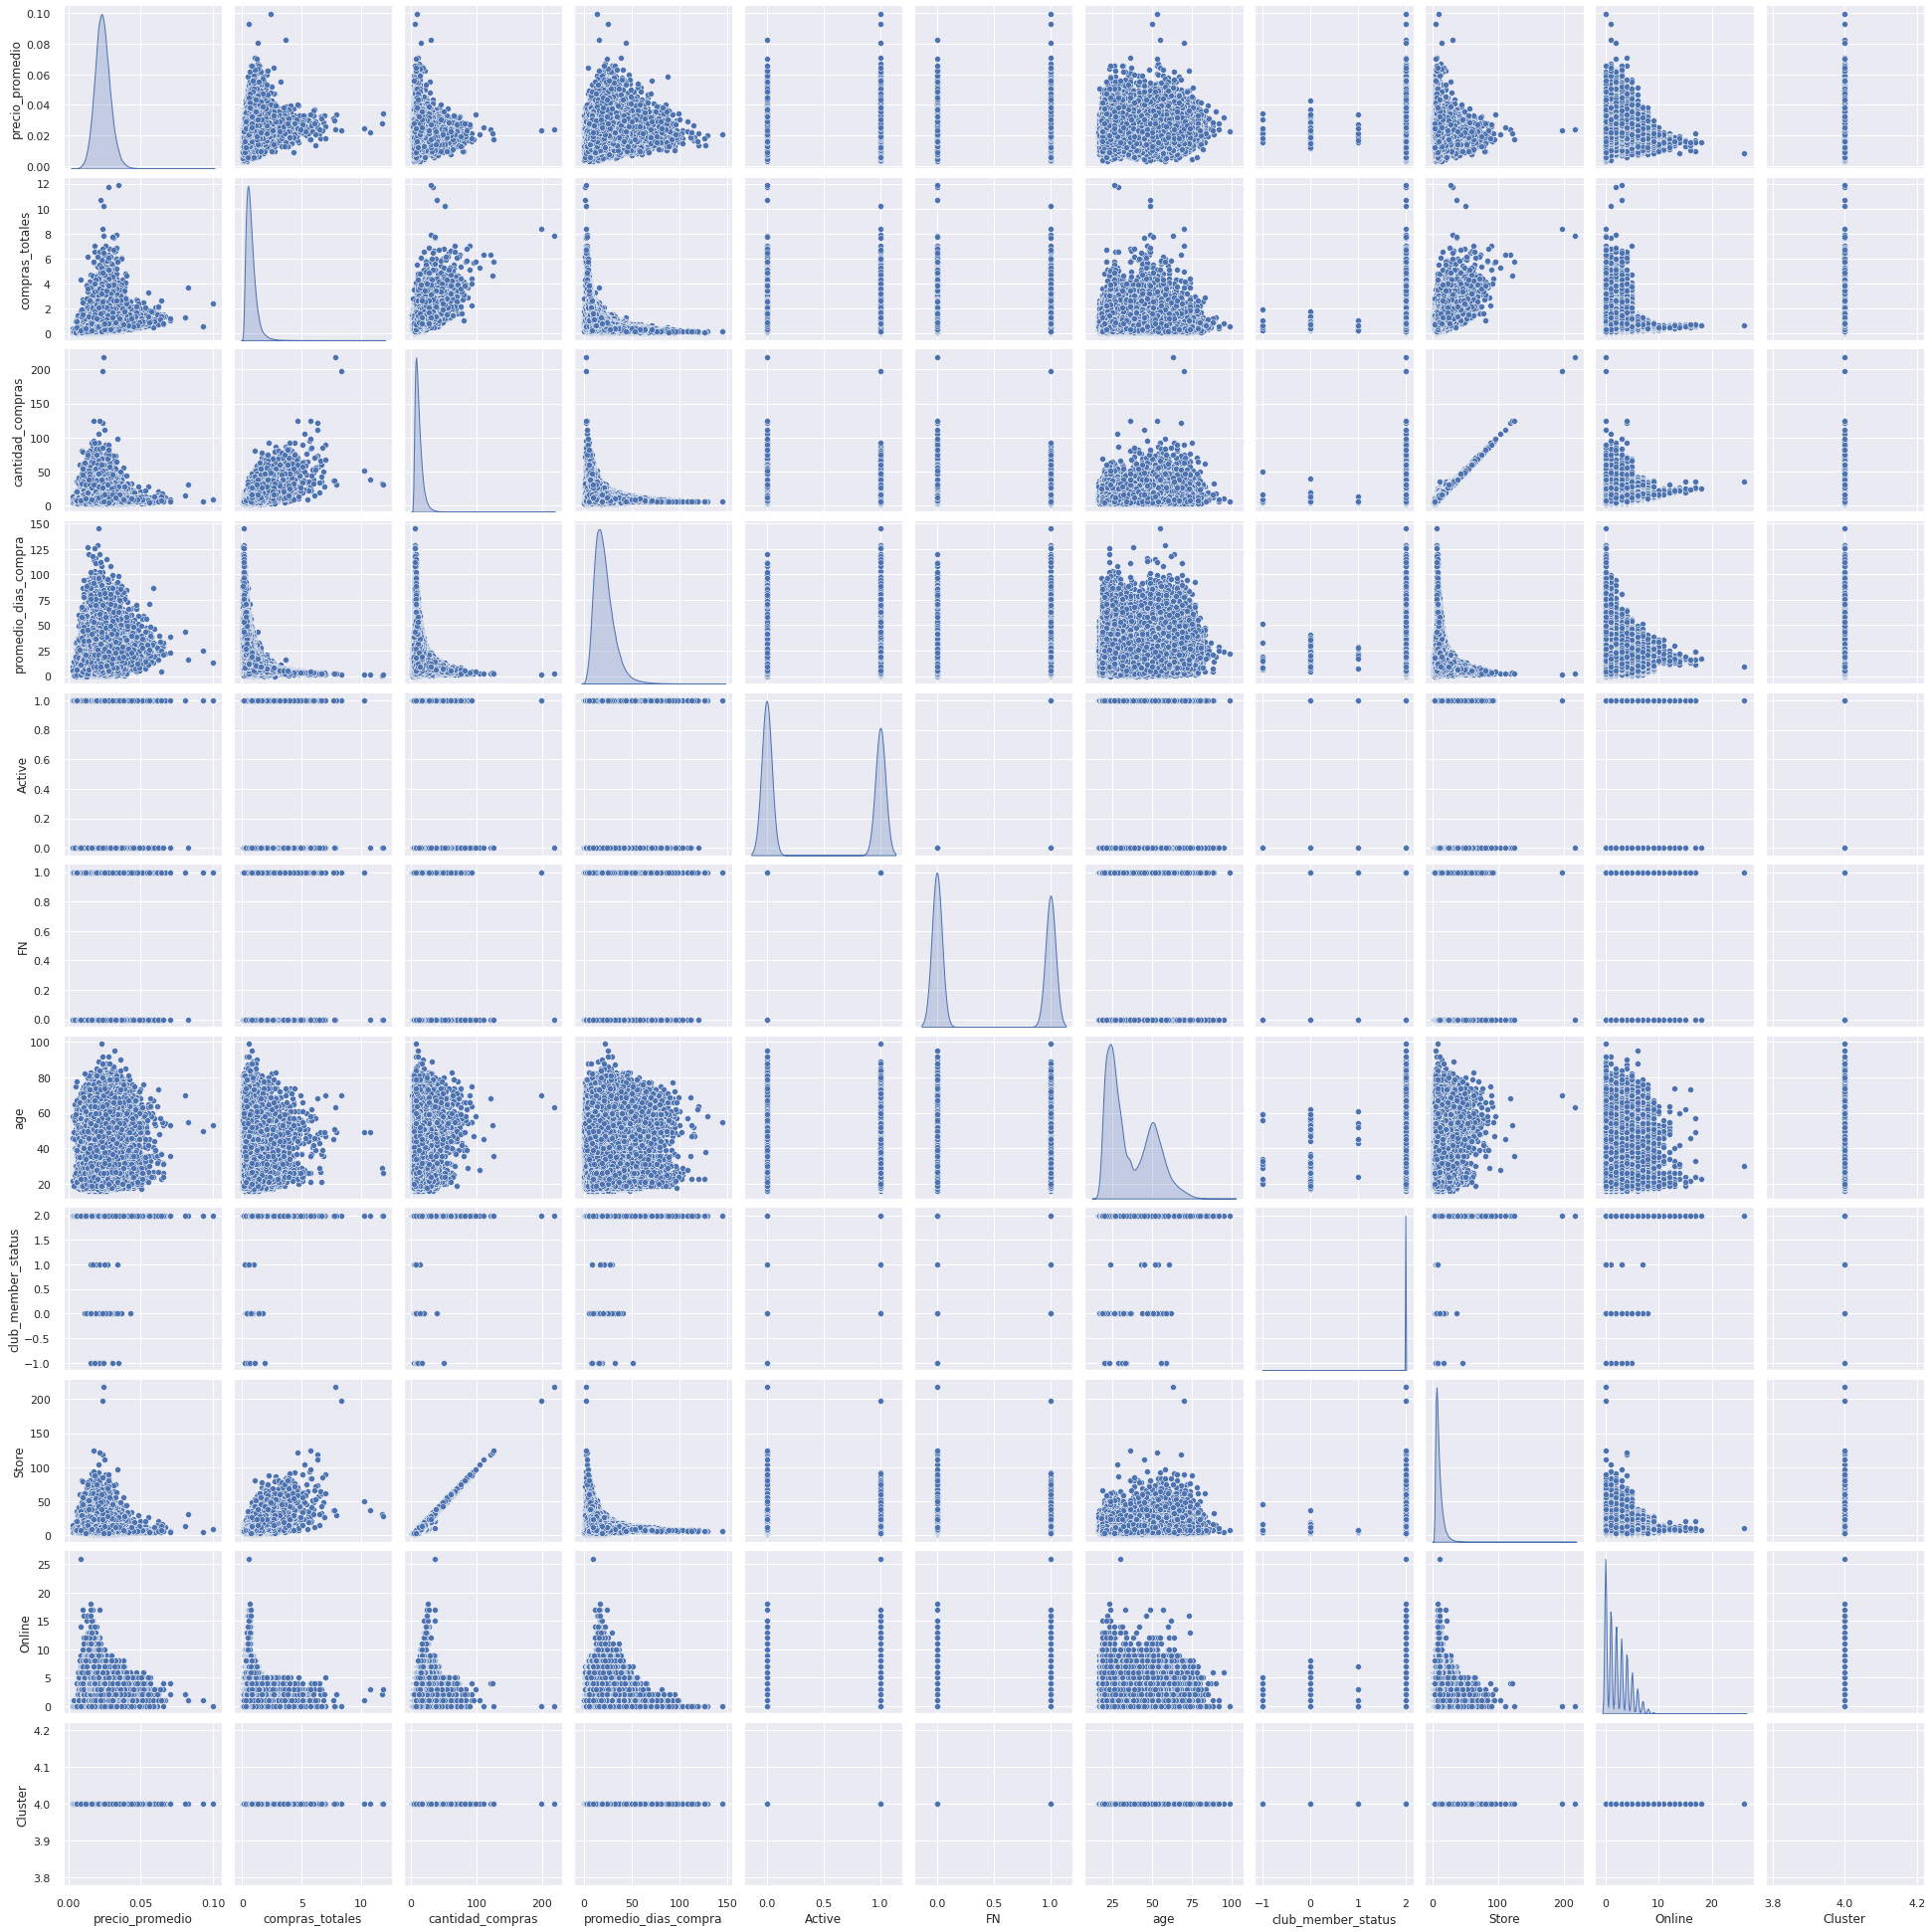

In [ ]:
dfcluster4 = df[df['Cluster']==4]
sns.pairplot(dfcluster4,diag_kind="kde")

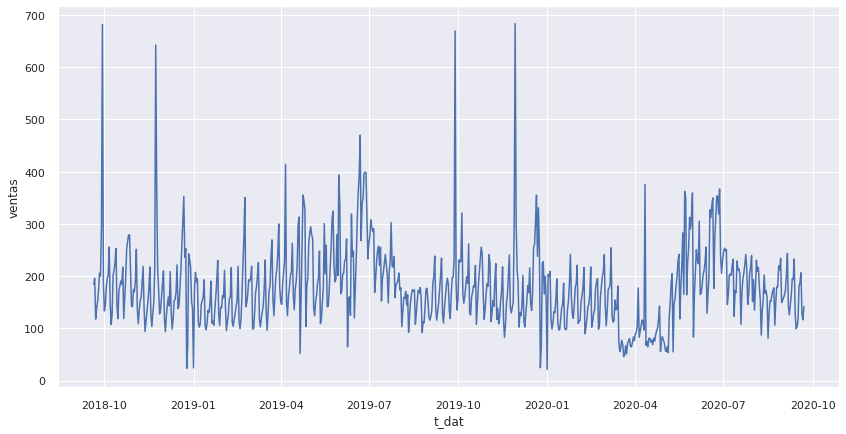

In [ ]:
aux5cluster4 = aux5[aux5['Cluster']==4]
fig, ax = plt.subplots(figsize=(14,7))

# multiple line plots
sns.lineplot(data=aux5cluster4, x='t_dat', y='ventas')

# show graph
plt.show()

In [ ]:
cluster_profile = df.groupby('K_means_segments').mean()

In [ ]:
# Obtenemos las etiquetas de cada punto de nuestros datos
labels = kmeans.predict(X)
# Obtenemos los centroids
C = kmeans.cluster_centers_
colores=['red','green','blue','cyan','yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

In [ ]:
#articles['article_id'] = articles['article_id'].astype(str)
articles['index_group_no'] = articles['index_group_no'].astype(str)
#transactions['article_id'] = transactions['article_id'].astype(str)

In [ ]:
temp = pd.merge(transactions[["customer_id", "article_id"]], articles[['article_id','index_group_no']], on="article_id", how='inner')

# check null values and drop it.
display(temp[temp.isnull().any(axis=1)])

temp = temp.dropna()

ca_matrix = pd.crosstab(index=temp.customer_id, columns=temp.index_group_no)
ca_matrix

In [ ]:
temp

In [ ]:
temp.dtypes

In [ ]:
transactions = transactions[["customer_id", "article_id", "price"]]
customers = customers[["customer_id", "age"]]
articles = articles[["article_id", "prod_name", "product_type_name", "product_group_name",
                     "department_name", "index_name", "index_group_name",
                     "section_name", "garment_group_name"]]



In [ ]:
temp = pd.merge(transactions, articles, on="article_id", how='inner')
temp = pd.merge(temp, customers, on="customer_id", how='inner')
temp